In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import random
from collections import Counter


import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold

### 1. Understanding dataset


In [ ]:
df = pd.read_csv("../../data/lending_club_loan_data.csv")

print(df.head())

print(f"Dataset shape: {df.shape}")

                 emp_title  emp_length state homeownership  annual_income  \
0  global config engineer          3.0    NJ      MORTGAGE        90000.0   
1   warehouse office clerk        10.0    HI          RENT        40000.0   
2                 assembly         3.0    WI          RENT        40000.0   
3         customer service         1.0    PA          RENT        30000.0   
4     security supervisor         10.0    CA          RENT        35000.0   

   verified_income  debt_to_income  annual_income_joint  \
0         Verified           18.01                  NaN   
1     Not Verified            5.04                  NaN   
2  Source Verified           21.15                  NaN   
3     Not Verified           10.16                  NaN   
4         Verified           57.96              57000.0   

  verification_income_joint  debt_to_income_joint  ...  sub_grade  \
0                       NaN                   NaN  ...         C3   
1                       NaN                 

#### 1.2 Check for missing values & fill fix them

- think about possible reasons why data is missing


In [3]:
print(df.isnull().sum())

emp_title                            833
emp_length                           817
state                                  0
homeownership                          0
annual_income                          0
verified_income                        0
debt_to_income                        24
annual_income_joint                 8505
verification_income_joint           8545
debt_to_income_joint                8505
delinq_2y                              0
months_since_last_delinq            5658
earliest_credit_line                   0
inquiries_last_12m                     0
total_credit_lines                     0
open_credit_lines                      0
total_credit_limit                     0
total_credit_utilized                  0
num_collections_last_12m               0
num_historical_failed_to_pay           0
months_since_90d_late               7715
current_accounts_delinq                0
total_collection_amount_ever           0
current_installment_accounts           0
accounts_opened_

## Possible reason for missing values

#### 1.emp_title (833 missing values)

    - borrowers choose not to disclose job title due to privacy concerns

    impact:
        - affect analysis related to employment sector and correlation to credit risk

#### 2. emp_length (817 missing values)

    - borrowers may omit this info if they have short employment history, self-employed or in informal / unverified jobs

    impact:
        - affect features correlating employment stability with default risk

#### 3. annual_income_joint, verification_income_joint, debt_to_income_joint (8505 - 8545 missing values)

    - specific to joint loan applicants
    - if borrower applied for individual loans, these fields are irrelevant

    impact:
        - missing values are expected and not representative of incomplete data

#### 4. months_since_last_delinq (5658 missing values)

    - possibly due to borrowers not having any delinquency history
    - inconsistent reporting / unverified borrower credit records can also lead to missing

    impact:
        - no delinquencies are lower risk but absence of this feature might limit credit behaviour analysis

#### 5. months_since_90d_late (7715 missing values)

    - missing values suggest that borrowers may not have record of being 90d late in credit payment
    - lack of reporting in credit history may also cause this issue

    impact:
        - missing values likely means borrower no severe delinquency but such assumption might lead to underestimation of risks for unreported cases

#### 6. debt_to_income (24 missing values)

    - borrowers did not provide complete information during loan application process
    - borrowers with atypical financial situation

    impact:
        - missing values could bias models & impact reliability


# Resolving Missing Values


In [4]:
print(df['emp_title'].unique())
print()
print(df['emp_length'].mean())
print(df['emp_length'].median())


['global config engineer ' 'warehouse office clerk' 'assembly' ...
 'inspector/packer' 'da coordinator ' 'toolmaker']

5.930306000217794
6.0


In [5]:
# categorical, use unknown
df['emp_title'] = df['emp_title'].fillna("unknown")

# mean is 5.93, median is 6. both is fine
df['emp_length'] = df['emp_length'].fillna(df['emp_length'].median())

# 0 to represent not applicable
df['annual_income_joint'] = df['annual_income_joint'].fillna(0)
df['verification_income_joint'] = df['verification_income_joint'].fillna("Not Applicable")
df['debt_to_income_joint'] = df['debt_to_income_joint'].fillna(0)

# assume no delinquency history
df['months_since_last_delinq'] = df['months_since_last_delinq'].fillna(0)


# assume 0 for borrowers without severe delinquency
df['months_since_90d_late'] = df['months_since_90d_late'].fillna(0)  # or 999

# dataset sufficiently large, can drop missing rows
df = df.dropna(subset=['debt_to_income'])

# central tendency without being influenced by outliers
df['months_since_last_credit_inquiry'] = df['months_since_last_credit_inquiry'].fillna(df['months_since_last_credit_inquiry'].median())

# assume no account past due
df['num_accounts_120d_past_due'] = df['num_accounts_120d_past_due'].fillna(0)



In [6]:
print(df.isnull().sum())
print(df.shape)

emp_title                           0
emp_length                          0
state                               0
homeownership                       0
annual_income                       0
verified_income                     0
debt_to_income                      0
annual_income_joint                 0
verification_income_joint           0
debt_to_income_joint                0
delinq_2y                           0
months_since_last_delinq            0
earliest_credit_line                0
inquiries_last_12m                  0
total_credit_lines                  0
open_credit_lines                   0
total_credit_limit                  0
total_credit_utilized               0
num_collections_last_12m            0
num_historical_failed_to_pay        0
months_since_90d_late               0
current_accounts_delinq             0
total_collection_amount_ever        0
current_installment_accounts        0
accounts_opened_24m                 0
months_since_last_credit_inquiry    0
num_satisfac

### 3 Summary Statistics & Data description

- identify features that are categorical, numerical, data/time
- generate summary statistics for numerical features to identify potential anomalies


In [7]:
numerical_features = df.select_dtypes(include=['int64', 'float64']).columns
categorical_features = df.select_dtypes(include='object').columns

print(f"Num of Numerical Features: {len(numerical_features)}")
print(f"Num of Categorical Features: {len(categorical_features)}")

Num of Numerical Features: 42
Num of Categorical Features: 13


In [8]:
categorical_features = categorical_features.drop('loan_status')

### Visualizing Numerical Stats

#### Boxplot

    - min, q1, median, q3, max
    - outliers
    - spot trends & patterns at a glance
    - skewness / symmetry of data
    - quick view of spread & central tendency

#### Symmetry of data

        - symmetry: left & right box equal in length, whiskers extend equally
        - symmetry = normal distribution (balanced)

#### Skewness of data (right) (positive skewed)

        - right tail long, box skewed leftwards
        - few high value outliers pulling average right
        - more data packed in lower values
        - eg: several high income earners, most average to low income earners
        - commonly found in finance data

#### Skewness of data (left) (negative skewed)

        - left tail long, box skewed rightwards
        - few low value outliers pulling average left
        - more data packed in higher value
        - eg: exam scores where most student did well except for few students who did poorly
        - less common that right skew


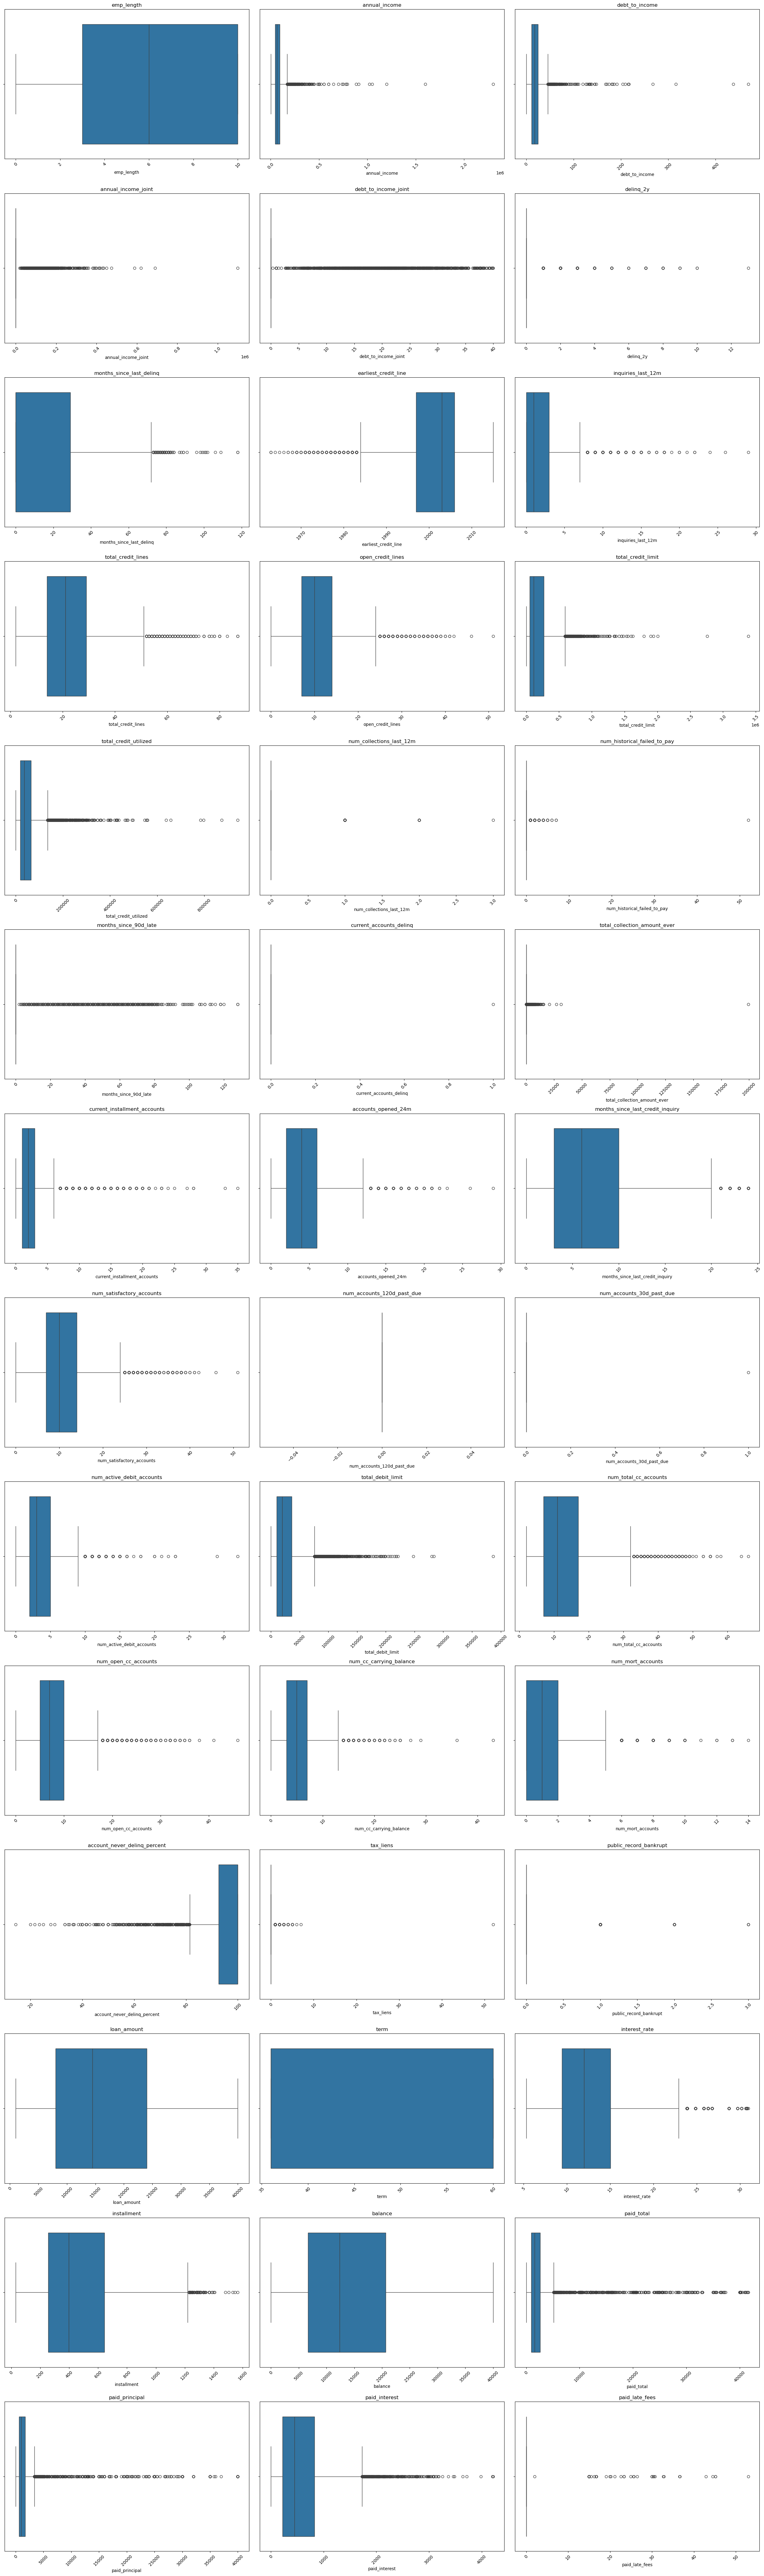

In [9]:
num_columns = 3
num_rows = len(numerical_features) // num_columns + (len(numerical_features) % num_columns != 0)  # To handle case when the number of columns isn't a multiple of 3

plt.figure(figsize=(25, 6 * num_rows))  # Adjust the height of the plot based on number of rows

# Create a box plot for each column
for i, col in enumerate(numerical_features):
    
    plt.subplot(num_rows, num_columns, i + 1)  # Adjust the grid size (num_rows, num_columns)
    sb.boxplot(data=df, x=col)
    plt.title(col)
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()
    



In [10]:
df['emp_title'].value_counts()

emp_title
unknown                     810
manager                     218
owner                       204
teacher                     201
driver                      123
                           ... 
phlebotomy supervisor         1
corporate tax director        1
captain-fire department       1
intervention specialist       1
toolmaker                     1
Name: count, Length: 4742, dtype: int64

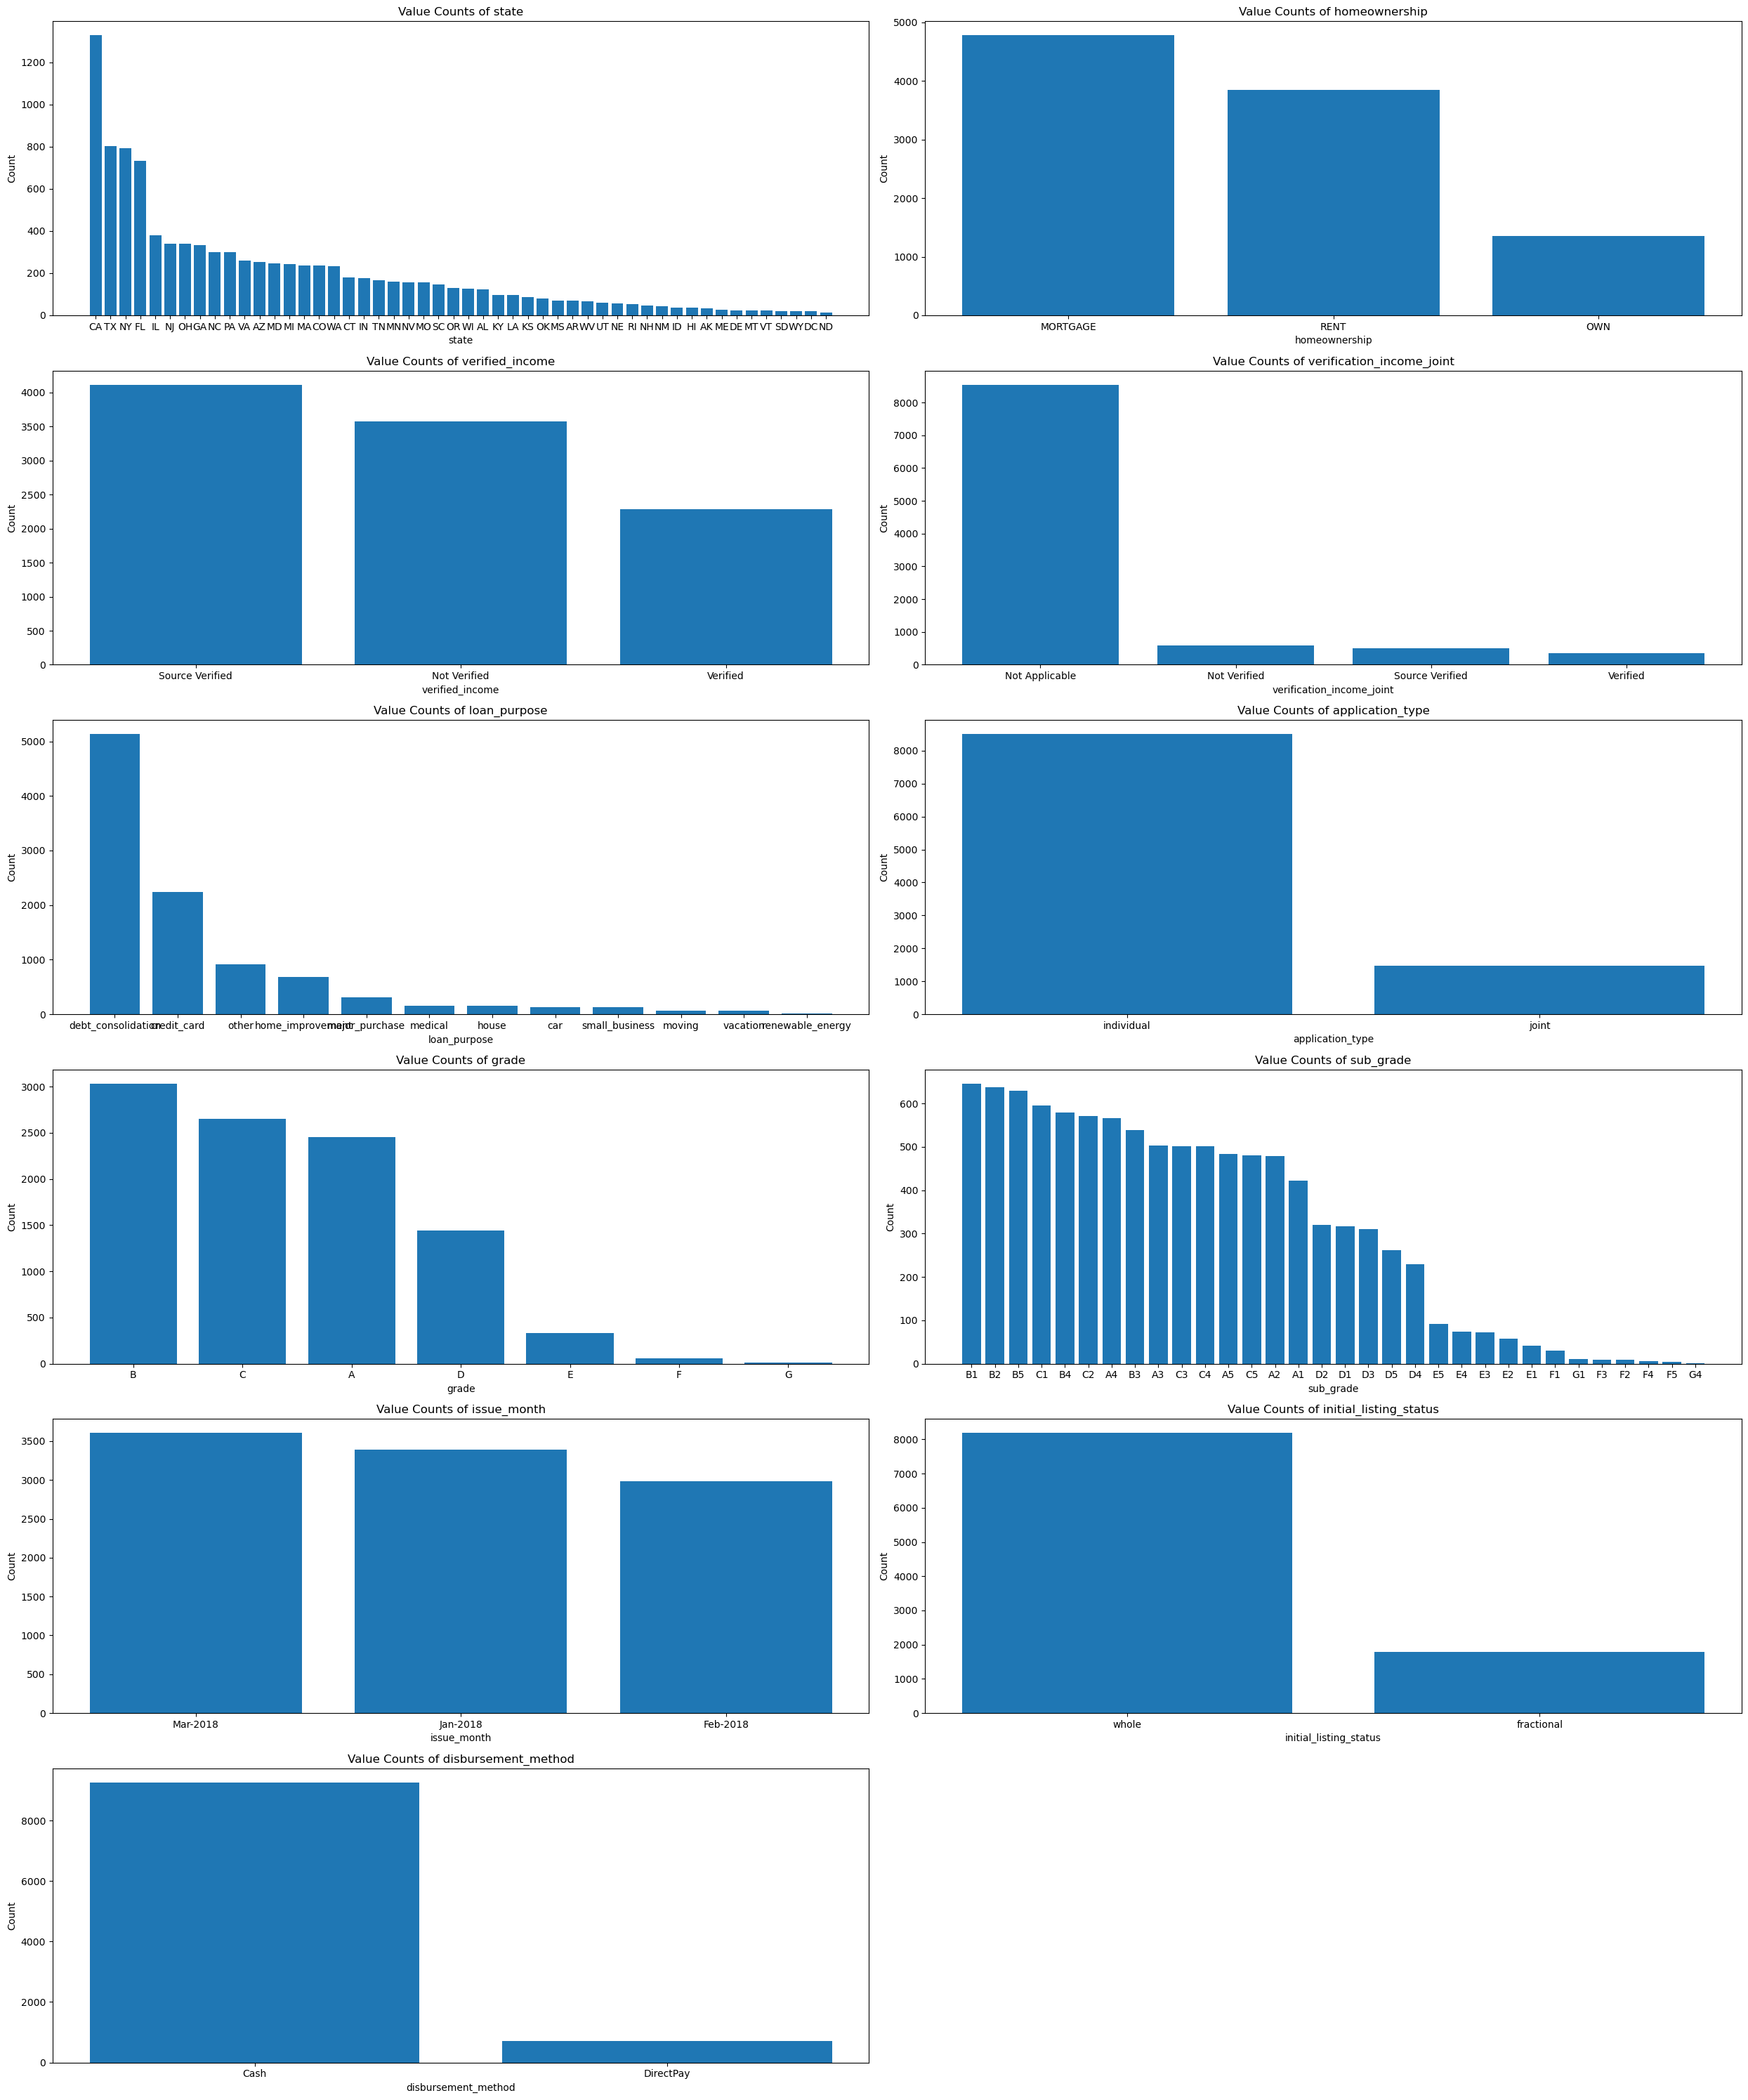

In [11]:
num_columns = 2
trim_categorical_features = categorical_features[1:]
num_rows = (len(trim_categorical_features) // num_columns) + (1 if len(trim_categorical_features) % num_columns != 0 else 0)

# Create a figure for the subplots
fig, axes = plt.subplots(num_rows, num_columns, figsize=(25, 5 * num_rows))

# Flatten the axes array to make it easier to index
axes = axes.flatten()

for idx, column in enumerate(trim_categorical_features):
    value_counts = df[column].value_counts()
    
    # Create bar plot for the value counts
    axes[idx].bar(value_counts.index, value_counts.values)
    axes[idx].set_title(f'Value Counts of {column}')
    axes[idx].set_xlabel(column)
    axes[idx].set_ylabel('Count')

# Remove empty subplots if number of columns doesn't divide evenly
for i in range(len(trim_categorical_features), len(axes)):
    fig.delaxes(axes[i])

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()

### 4. Explore Target Variable


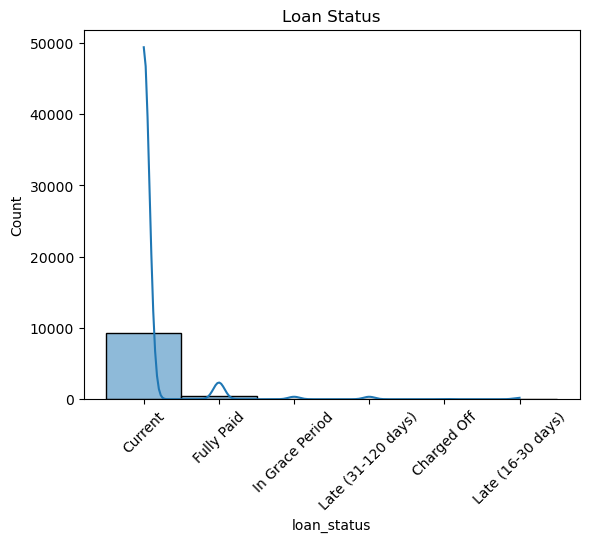

In [12]:

target = 'loan_status'
sb.histplot(df[target], kde=True)
plt.title("Loan Status")
plt.xticks(rotation=45)
plt.show()


loan_status
Current               9354
Fully Paid             445
In Grace Period         66
Late (31-120 days)      66
Late (16-30 days)       38
Charged Off              7
Name: count, dtype: int64


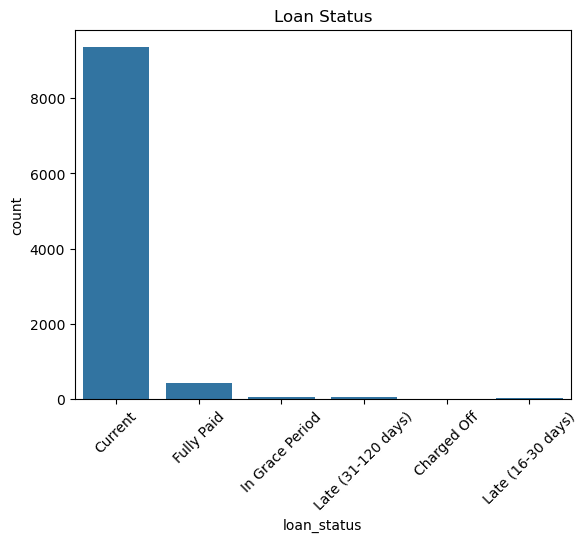

In [13]:
print(df[target].value_counts())
sb.countplot(x=target, data=df)
plt.title("Loan Status")
plt.xticks(rotation=45)
plt.show()

### 5. Handle Categorical Variables

- label encoding : use when categorical feature has ordinal relationship (order matters)
- 1-hot encoding : use when categorical feature has non-ordinal relationship (order doesnt matter)

label-encoding:

1-hot encoding: emp_title, state, homeownership, verified_income, verification_income_joint, loan_purpose,


In [14]:
df.head(5)

,emp_title,emp_length,state,homeownership,annual_income,verified_income,debt_to_income,annual_income_joint,verification_income_joint,debt_to_income_joint,...,sub_grade,issue_month,loan_status,initial_listing_status,disbursement_method,balance,paid_total,paid_principal,paid_interest,paid_late_fees
0,global config engineer,3.0,NJ,MORTGAGE,90000.0,Verified,18.01,0.0,Not Applicable,0.00,...,C3,Mar-2018,Current,whole,Cash,27015.86,1999.33,984.14,1015.19,0.0
1,warehouse office clerk,10.0,HI,RENT,40000.0,Not Verified,5.04,0.0,Not Applicable,0.00,...,C1,Feb-2018,Current,whole,Cash,4651.37,499.12,348.63,150.49,0.0
2,assembly,3.0,WI,RENT,40000.0,Source Verified,21.15,0.0,Not Applicable,0.00,...,D1,Feb-2018,Current,fractional,Cash,1824.63,281.80,175.37,106.43,0.0
3,customer service,1.0,PA,RENT,30000.0,Not Verified,10.16,0.0,Not Applicable,0.00,...,A3,Jan-2018,Current,whole,Cash,18853.26,3312.89,2746.74,566.15,0.0
4,security supervisor,10.0,CA,RENT,35000.0,Verified,57.96,57000.0,Verified,37.66,...,C3,Mar-2018,Current,whole,Cash,21430.15,2324.65,1569.85,754.80,0.0


In [15]:
for col in categorical_features:
    print(df[col].unique())
    


['global config engineer ' 'warehouse office clerk' 'assembly' ...
 'inspector/packer' 'da coordinator ' 'toolmaker']
['NJ' 'HI' 'WI' 'PA' 'CA' 'KY' 'MI' 'AZ' 'NV' 'IL' 'FL' 'SC' 'CO' 'TN'
 'TX' 'VA' 'NY' 'GA' 'MO' 'AR' 'MD' 'NC' 'NE' 'WV' 'NH' 'UT' 'DE' 'MA'
 'OR' 'OH' 'OK' 'SD' 'MN' 'AL' 'WY' 'LA' 'IN' 'KS' 'MS' 'WA' 'ME' 'VT'
 'CT' 'NM' 'AK' 'MT' 'RI' 'ND' 'DC' 'ID']
['MORTGAGE' 'RENT' 'OWN']
['Verified' 'Not Verified' 'Source Verified']
['Not Applicable' 'Verified' 'Not Verified' 'Source Verified']
['moving' 'debt_consolidation' 'other' 'credit_card' 'home_improvement'
 'medical' 'house' 'small_business' 'car' 'major_purchase' 'vacation'
 'renewable_energy']
['individual' 'joint']
['C' 'D' 'A' 'B' 'F' 'E' 'G']
['C3' 'C1' 'D1' 'A3' 'C2' 'B5' 'C4' 'B2' 'B1' 'D3' 'F1' 'E5' 'A2' 'A5'
 'A4' 'A1' 'D4' 'D5' 'B3' 'D2' 'E1' 'G1' 'B4' 'C5' 'E2' 'E4' 'F3' 'E3'
 'F5' 'F2' 'F4' 'G4']
['Mar-2018' 'Feb-2018' 'Jan-2018']
['whole' 'fractional']
['Cash' 'DirectPay']


#### Handling emp_title

- emp_title has 4742 unique job titles.
- this increases the dimensionality significantly

##### Solution:

- group titles into categories


In [16]:
df.emp_title.nunique()

4742

In [17]:
for t in df.emp_title.unique():
    print(t)

global config engineer 
warehouse office clerk
assembly
customer service
security supervisor 
unknown
hr 
police
parts
4th person
supervisor
register nurse
respiratory therapist & sleep lab tech
senior inspector
dental hygienist
onsite medical 
operational risk manager
welder
maintenance adm assistant
warranty administrator
underwriter
program analyst 
surveyor/cadd tech
associated 
inventory control specialist
inventory control
sr direct supoort professional
director of operations
hospitalist
teacher
controller
deputy
armed protection officer 
driver
supplies clerk
loan consultant 
bank coordinator
senior recruiter
reader advisor
truck driver
sales
director of support services
rn
police recruit
lead teller
registered nurse
hes advisor 
sr admin assistant
president
hvac technician
nurse assistant
gourmet food server
program manager
deputy assessor 
service tech
senior technically writer
escrow manager
quality control
medical billing account rep
general manager
bartender
interpreter/tra

#### Keywords mapping:

- manage -> manager
-


In [18]:
df.shape

(9976, 55)

In [19]:
categorical_features = categorical_features[1:]

In [20]:
categorical_features

Index(['state', 'homeownership', 'verified_income',
       'verification_income_joint', 'loan_purpose', 'application_type',
       'grade', 'sub_grade', 'issue_month', 'initial_listing_status',
       'disbursement_method'],
      dtype='object')

In [21]:

df = pd.get_dummies(df, columns=list(categorical_features), drop_first=True)


In [22]:
df.shape

(9976, 153)

In [23]:
X = df.drop(columns=['loan_status', 'emp_title'], axis=1)
y = df['loan_status']

X = X.astype(int)

In [24]:
X.shape

(9976, 151)

### Feature Importance

- emp_title has 4742 unique values, and will be dropped to prevent dimension increasing
- after 1-hot encoding, columns expand from 55 -> 153
- use reduction in impurity to find feature importance


### Analyzing Data & Resampling to address class imbalance


### Hybrid (Oversample + Undersample)


In [25]:
y.value_counts()

loan_status
Current               9354
Fully Paid             445
In Grace Period         66
Late (31-120 days)      66
Late (16-30 days)       38
Charged Off              7
Name: count, dtype: int64

In [26]:
target_count = 0
for c in df['loan_status'].value_counts()[1:]:
    target_count += c

target_count = target_count / (len(list(df['loan_status'].unique())) - 1)
target_count = int(target_count)

In [27]:
# target_count = 500

# Undersample majority data
majority_class = df[df['loan_status'] == "Current"].sample(n=target_count, random_state=random.randint(1, 100))

# Oversample minority classes
oversampled_minority_data = []
for label, count in y.value_counts().items():
    if label != 'Current':
        class_data = df[df['loan_status'] == label]
        oversampled_class_data = class_data.sample(target_count, replace=True, random_state=random.randint(1, 100))
        oversampled_minority_data.append(oversampled_class_data)

hybrid_data = pd.concat([majority_class] + oversampled_minority_data)

# shuffle data
hybrid_data = hybrid_data.sample(frac=1, random_state=random.randint(0, 100)).reset_index(drop=True)
hybrid_data = hybrid_data.reset_index(drop=True)

X_resampled = hybrid_data.drop('loan_status', axis=1)
y_resampled = hybrid_data['loan_status']


print("Before Resampling:")
print(y.value_counts())
print("\nAfter Resampling:")
print(y_resampled.value_counts())
 

Before Resampling:
loan_status
Current               9354
Fully Paid             445
In Grace Period         66
Late (31-120 days)      66
Late (16-30 days)       38
Charged Off              7
Name: count, dtype: int64

After Resampling:
loan_status
Late (31-120 days)    124
Fully Paid            124
In Grace Period       124
Current               124
Late (16-30 days)     124
Charged Off           124
Name: count, dtype: int64


In [28]:
X_resampled = X_resampled.drop('emp_title', axis=1)
X_resampled = X_resampled.astype(int)
X_resampled.shape

(744, 151)

### Prepping data with just minority classes


In [29]:
X_minority_df = df[df['loan_status'] != 'Current']
y_minority_df = df[df['loan_status'] != 'Current']['loan_status']

X_minority_df = X_minority_df.drop(['emp_title', 'loan_status'], axis=1)
X_minority_df = X_minority_df.astype(int)


### 6. Split for K-fold Cross Validation


In [30]:
# X_data = X_resampled.values
# y_data = y_resampled.values

X_data = X_minority_df.values
y_data = y_minority_df.values

n_splits = 5 # 5 fold cross validation
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random.randint(1,100))


### 7. Building the Classifier Model


In [31]:
class CustomDecisionTreeClassifier:
    def __init__(self, max_depth=None):
        self.max_depth = max_depth # control max depth to prevent overfitting
        self.tree = None
    
    def fit(self, X, y):
        self.tree = self._build_tree(X, y, depth=0)
    
    def predict(self, X):
        return np.array([self._predict_sample(sample, self.tree) for sample in X])

    def _build_tree(self, X, y, depth):
            if len(y) == 0:
                return {'leaf': True, 'label': 'Unknown'}
            
            # depth = current depth of tree
            if len(set(y)) == 1 or (self.max_depth is not None and depth >= self.max_depth):
                return {'leaf': True, 'label': Counter(y).most_common(1)[0][0]}
        
            # Find best split
            n_samples, n_features = X.shape
            best_feature, best_threshold, best_gini = None, None, float('inf')
            for feature in range(n_features):
                thresholds = np.unique(X[:, feature]) # Unique value for the features
                for threshold in thresholds:
                    # Compute Gini index for split
                    gini = self._compute_gini(y, X[:, feature], threshold)
                    if gini < best_gini:
                        best_gini = gini
                        best_feature = feature
                        best_threshold = threshold
            
            # split dataset based on best split
            left_indices = X[:, best_feature] <= best_threshold
            right_indices = X[:, best_feature] > best_threshold
            left_tree = self._build_tree(X[left_indices], y[left_indices], depth + 1)
            right_tree = self._build_tree(X[right_indices], y[right_indices], depth + 1)
            
            return {
                'leaf': False,
                'feature': best_feature,
                'threshold': best_threshold,
                'left': left_tree,
                'right': right_tree
            }
    
    # compute gini impurity for split   
    def _compute_gini(self, y, feature_col, threshold):
        left_indices = feature_col <= threshold
        right_indices = feature_col > threshold
        
        def gini_impurity(indices):
            if len(indices) == 0:
                return 0

            label_counts = Counter(y[indices])
            total_count = len(indices)
            return 1 - sum((count / total_count) ** 2 for count in label_counts.values())

        n_left, n_right = sum(left_indices), sum(right_indices)
        n_total = n_left + n_right
        gini_left = gini_impurity(left_indices)
        gini_right = gini_impurity(right_indices)

        # Weighted average Gini impurity
        return (n_left / n_total) * gini_left + (n_right / n_total) * gini_right

    def _predict_sample(self, sample, tree):
        """
        Predict the label for a single sample.
        :param sample: Feature values of the sample.
        :param tree: The current node of the tree.
        :return: Predicted label.
        """
        if tree['leaf']:
            return tree['label']
        if sample[tree['feature']] <= tree['threshold']:
            return self._predict_sample(sample, tree['left'])
        else:
            return self._predict_sample(sample, tree['right'])
    


### 8 Train the decision tree classifier


In [32]:
def calculate_accuracy(y_true, y_pred):
    correct = sum(1 for true, pred in zip(y_true, y_pred) if true == pred)
    return correct / len(y_true)

def generate_classification_report(y_true, y_pred, target_names):
    """
    Generate a classification report showing precision, recall, F1-score, and support for each class.
    :param y_true: List of true labels.
    :param y_pred: List of predicted labels.
    :param target_names: List of class names corresponding to labels.
    :return: Formatted classification report as a string.
    """
    report = []
    class_counts = Counter(y_true)
    unique_classes = sorted(class_counts.keys())  # Ensure consistent ordering
    metrics = {}

    for cls in unique_classes:
        # True positives
        tp = sum(1 for true, pred in zip(y_true, y_pred) if true == cls and pred == cls)
        # False positives
        fp = sum(1 for true, pred in zip(y_true, y_pred) if true != cls and pred == cls)
        # False negatives
        fn = sum(1 for true, pred in zip(y_true, y_pred) if true == cls and pred != cls)
        # Support (number of true instances of the class)
        support = class_counts[cls]
        # Precision, recall, F1-score
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1_score = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        metrics[cls] = {
            'precision': precision,
            'recall': recall,
            'f1_score': f1_score,
            'support': support,
        }

    # Build the formatted report
    report.append(f"{'Class':<25} {'Precision':<10} {'Recall':<10} {'F1-Score':<10} {'Support':<10}")
    report.append("-" * 65)
    for cls, cls_name in zip(unique_classes, target_names):
        precision = metrics[cls]['precision']
        recall = metrics[cls]['recall']
        f1_score = metrics[cls]['f1_score']
        support = metrics[cls]['support']
        report.append(f"{cls_name:<25} {precision:<10.2f} {recall:<10.2f} {f1_score:<10.2f} {support:<10}")

    # Calculate overall metrics (micro and macro averages)
    total_support = sum(metrics[cls]['support'] for cls in unique_classes)
    macro_precision = sum(metrics[cls]['precision'] for cls in unique_classes) / len(unique_classes)
    macro_recall = sum(metrics[cls]['recall'] for cls in unique_classes) / len(unique_classes)
    macro_f1 = sum(metrics[cls]['f1_score'] for cls in unique_classes) / len(unique_classes)

    report.append("\nOverall Metrics:")
    report.append(f"  Macro Precision: {macro_precision:.2f}")
    report.append(f"  Macro Recall: {macro_recall:.2f}")
    report.append(f"  Macro F1-Score: {macro_f1:.2f}")
    report.append(f"  Total Support: {total_support}")

    return "\n".join(report)


In [35]:
tree = CustomDecisionTreeClassifier(max_depth=8)

fold = 1
accuracy_scores = []

for train_index, test_index in skf.split(X_data, y_data):
    print(f"Processing Fold {fold}")
    X_train, X_test = X_data[train_index], X_data[test_index]
    y_train, y_test = y_data[train_index], y_data[test_index]
    
    # train the model
    tree.fit(X_train, y_train)
    
    # make prediction
    y_pred = tree.predict(X_test)
    
    # calculate accuracy
    accuracy = calculate_accuracy(y_test, y_pred)
    accuracy_scores.append(accuracy)
    
    print(f"fold {fold} - accuracy: {accuracy}")
    print(generate_classification_report(y_test, y_pred, target_names=list(df[target].unique())))
    
    fold += 1

Processing Fold 1
fold 1 - accuracy: 0.712
Class                     Precision  Recall     F1-Score   Support   
-----------------------------------------------------------------
Current                   0.00       0.00       0.00       1         
Fully Paid                0.71       1.00       0.83       89        
In Grace Period           0.00       0.00       0.00       14        
Late (31-120 days)        0.00       0.00       0.00       8         
Charged Off               0.00       0.00       0.00       13        

Overall Metrics:
  Macro Precision: 0.14
  Macro Recall: 0.20
  Macro F1-Score: 0.17
  Total Support: 125
Processing Fold 2
fold 2 - accuracy: 0.712
Class                     Precision  Recall     F1-Score   Support   
-----------------------------------------------------------------
Current                   0.00       0.00       0.00       1         
Fully Paid                0.71       1.00       0.83       89        
In Grace Period           0.00       0.00    

In [34]:
print("\nCross-Validation Results:")
print(f"Average Accuracy: {np.mean(accuracy_scores):.4f}")
print(f"Accuracy Scores per Fold: {accuracy_scores}")


Cross-Validation Results:
Average Accuracy: 0.7154
Accuracy Scores per Fold: [0.712, 0.712, 0.717741935483871, 0.717741935483871, 0.717741935483871]


### 9 Test Model & Perform Prediction of new Data


In [50]:
df_cols = list(df.columns)
df_cols.remove('loan_status')
df_cols.append('loan_status')
df = df[df_cols]
df.head(1)

df_features = df.drop(columns='loan_status')

In [51]:
df['pred_loan_status'] = None

for i in range(len(df_features)):
    cur_row = df_features.iloc[i]
    pred = tree.predict([cur_row])
    df['pred_loan_status'] = pred[0]
    

/var/folders/fc/n6ycqzwx13989g40ry2djdsh0000gn/T/ipykernel_30372/2541681354.py:77: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if sample[tree['feature']] <= tree['threshold']:


UFuncTypeError: ufunc 'greater_equal' did not contain a loop with signature matching types (<class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.StrDType'>) -> None

In [ ]:
hybrid_data['pred_loan_status'] = None

for i in range(len(hybrid_data)):
    cur_row = hybrid_data.iloc[i]
    pred = tree.predict([cur_row])
    hybrid_data['pred_loan_status'] = pred[0]

In [ ]:
hybrid_data[['loan_status', 'pred_loan_status']]

In [ ]:
df[df['loan_status'] != df['pred_loan_status']].shape

In [ ]:
df[df['loan_status'] != df['pred_loan_status']][['loan_status','pred_loan_status']]

In [ ]:
df[['loan_status', 'pred_loan_status']]